# Registration of Sentinel-2 with NAIP 2019

### Import Packages

In [16]:
# Import packages

from pathlib import Path
from arosics import COREG, COREG_LOCAL, DESHIFTER
from geoarray import GeoArray
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os

### Path Setup

In [2]:
# Set the working directory

wd = Path('F:/FORCE/corregistration')
assert wd.exists()

### Load the Reference Image

In [3]:
# Select and read title of intest from NAIP

basemap_file = wd/'X0016_Y0024/NAIP_X0016_Y0024.tif' #This is the NAIP scene of 2019 for the title of interest
reference = GeoArray(str(basemap_file))

# Plot raster
reference.show(figsize = (15, 15))

### Load Target Image

In [5]:
# Select and the image/title of interest from Sentinel-2

target_file = wd/'X0016_Y0024/X0016_Y0024_red.tif' #This is the average RED band for the groing period of 2019
target = GeoArray(str(target_file))

# Plot raster
target.show(figsize = (15, 15))

### Coregistration to a Basemap Image

In [6]:
# Sometimes the projections does not match. Let's force them to be the same regardless if they are equal.
if reference.projection == target.projection:
    reference.projection = target.projection
else:
    print("Stop, you need to check the projection to continue")    

In [7]:
# Setup parameters for tiepoint detection and affine transformation factor calculation
coreg_kwargs = {
    'grid_res': 100, # Tie point spacing in x-direction, in terms of target image pixels
    'window_size': (164, 164), # Size of matching window
    'nodata': (0.0, -9999), # No-data values for reference & target images
    'max_iter': 8,
    'r_b4match': 3, # Reference band for matching
    's_b4match': 1, # Target band for matching
    'CPUs': 4,      # For Ubuntu only
    'max_shift': 150,
    'min_reliability': 20
}

# Apply local image coregistration
CRL = COREG_LOCAL(reference, target, **coreg_kwargs)

# Inspect the result
CRL.correct_shifts()

Calculating footprint polygon and actual data corner coordinates for reference image...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:14


Bounding box of calculated footprint for reference image:
	(194888.1532, 701064.19, 225888.3281, 730539.7613)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...


C:\Users\guzman\Anaconda3\envs\arosics\lib\site-packages\geoarray\baseclasses.py:733: RuntimeWarning: Mean of empty slice
  if np.nanmean(bandmeans) == self.nodata:


Bounding box of calculated footprint for image to be shifted:
	(199292.51690292917, 705980.1870542851, 229292.51690292917, 735980.1870542851)
Matching window position (X,Y): 211875.34754871845/717938.1428489388
Initializing tie points grid...
Equalizing pixel grids and projections of reference and target image...


Warping progress     |==================================================| 100.0% Complete  => 0:00:02


Calculating tie point grid (618 points) using 4 CPU cores...


OSError: [Errno 22] Invalid argument

In [8]:
with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'): # Ignore AROSICS complaining
    result = CRL.correct_shifts()

Calculating tie point grid (618 points) using 4 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:15


Found 439 matches.
Performing validity checks...
13 tie points flagged by level 1 filtering (reliability).
83 tie points flagged by level 2 filtering (SSIM).
32 tie points flagged by level 3 filtering (RANSAC)
314 valid tie points remain after filtering.
Correcting geometric shifts...


C:\Users\guzman\Anaconda3\envs\arosics\lib\site-packages\arosics\DeShifter.py:291: UserWarning: 
The coordinate grid of X0016_Y0024_red cannot be aligned to the desired grid because their pixel sizes are not exact multiples of each other (input [X/Y]: 10.0/10.0; desired [X/Y]: 0.5803211385500617/0.6205122163519263). Therefore the original grid is chosen for the resampled output image. If you don´t like that you can use the 'out_gsd' or 'match_gsd' parameters to set an appropriate output pixel size or to allow changing the pixel size.

  warnings.warn("\nThe coordinate grid of %s cannot be aligned to the desired grid because their pixel "
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Note: array has been downsampled to 1000 x 1000 for faster visualization.


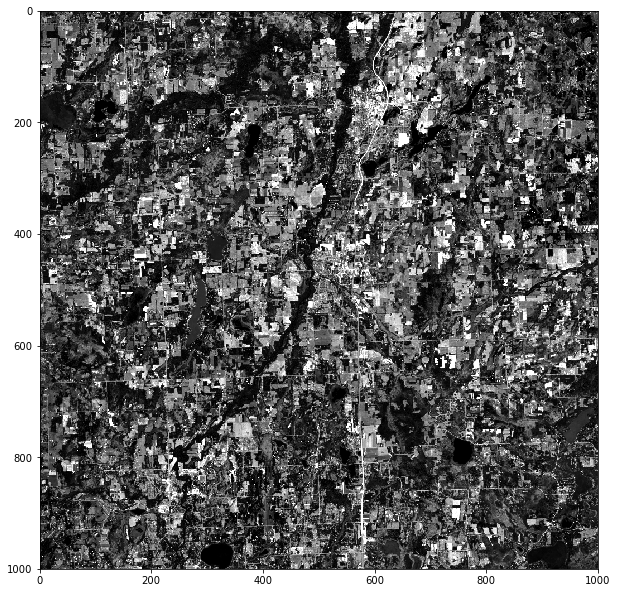

C:\Users\guzman\Anaconda3\envs\arosics\lib\site-packages\py_tools_ds\geo\projection.py:169: RuntimeWarning: Could not find a suitable EPSG code for the input WKT string.
  warnings.warn('Could not find a suitable EPSG code for the input WKT string.', RuntimeWarning)


Note: array has been downsampled to 1000 x 1000 for faster visualization.


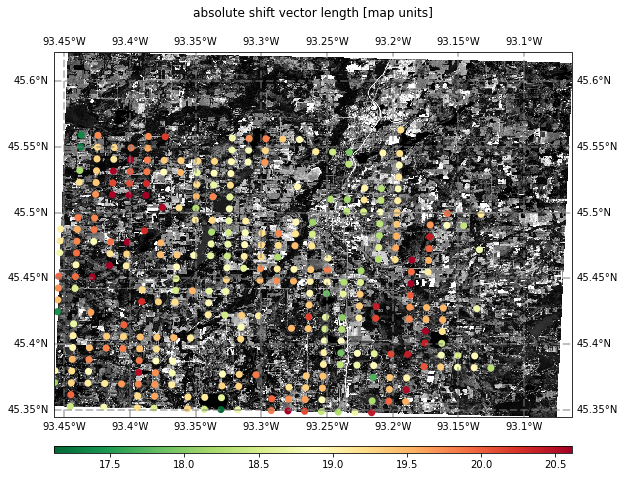

In [9]:
# Show the corrected target image geoarray
result['GeoArray_shifted'].show(figsize = (10, 15))

# Show tie points on top of the target image
CRL.view_CoRegPoints()

In [10]:
# Show the points table of the calculated tie point grid
# Notes: Point records where no valid match has been found are filled with -9999.0
# False-positive "labeled as False" points are not used to compute transformation factors
CRL.CoRegPoints_table

,geometry,POINT_ID,X_IM,Y_IM,X_MAP,Y_MAP,REF_BADDATA,TGT_BADDATA,X_WIN_SIZE,Y_WIN_SIZE,...,ANGLE,SSIM_BEFORE,SSIM_AFTER,SSIM_IMPROVED,RELIABILITY,LAST_ERR,L1_OUTLIER,L2_OUTLIER,L3_OUTLIER,OUTLIER
0,POINT (199292.517 729980.187),186,0,600,199292.516903,729980.187054,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999
1,POINT (200292.517 729980.187),187,100,600,200292.516903,729980.187054,False,False,66.0,68.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,No match found in the given window.,-9999,-9999,-9999,-9999
2,POINT (201292.517 729980.187),188,200,600,201292.516903,729980.187054,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999
3,POINT (202292.517 729980.187),189,300,600,202292.516903,729980.187054,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999
4,POINT (203292.517 729980.187),190,400,600,203292.516903,729980.187054,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,POINT (216292.517 705980.187),947,1700,3000,216292.516903,705980.187054,False,False,164.0,80.0,...,134.140203,0.321533,0.569869,True,67.208466,-9999,False,False,False,False
614,POINT (217292.517 705980.187),948,1800,3000,217292.516903,705980.187054,False,False,164.0,80.0,...,135.408763,0.246439,0.521191,True,65.734551,-9999,False,False,False,False
615,POINT (218292.517 705980.187),949,1900,3000,218292.516903,705980.187054,False,False,164.0,80.0,...,130.726134,0.191836,0.398574,True,39.627286,-9999,False,False,False,False
616,POINT (219292.517 705980.187),950,2000,3000,219292.516903,705980.187054,False,False,164.0,80.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,No match found in the given window.,-9999,-9999,-9999,-9999


In [12]:
# Export tie point grid to an ESRI point shapefile
tiepoint_file = wd/('X0016_Y0024/tiepoint')

CRL.tiepoint_grid.to_PointShapefile(path_out = tiepoint_file)

Writing F:\FORCE\corregistration\X0016_Y0024\tiepoint ...


C:\Users\guzman\Anaconda3\envs\arosics\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\guzman\Anaconda3\envs\arosics\lib\site-packages\arosics\Tie_Point_Grid.py:888: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  GDF2pass.to_file(path_out)


### Applying Calculated Shifts

In [13]:
# Apply previously-calculated shifts to the full-band image
deshifter = DESHIFTER(target, CRL.coreg_info)

# Warp the full-band image "with the cubic convolution resampling"
target_shifted_all_bands = deshifter.correct_shifts()

# Get shifted GeoArray
target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

# Set file path to shifted image
target_file_shifted_all_bands = wd/('X0016_Y0024/tiepoint/corg_Sentinel2_X0016_Y0024.tif')

# Save the shifted image into GTiff, use this image for manual assessment.
target_geoarray_shifted_all_bands.save(str(target_file_shifted_all_bands),
                                       fmt = 'GTiff', creationOptions = ["WRITE_METADATA=YES"])

Translating progress |============--------------------------------------| 25.0% Complete  => 0:00:00

Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\corregistration\X0016_Y0024\tiepoint\corg_Sentinel2_X0016_Y0024.tif.


### Apply shifts in a batch

In [17]:
# If the corrections works you can apply it in a batch.
# Select input path
in_wd = Path('F:/FORCE/level3_VI/X0016_Y0024')

# Select output path
out_wd = Path('F:/FORCE/level3_shifted/X0016_Y0024')

# List images to transform 
files = os.listdir(in_wd)
files

['2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20170616_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210817_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20170507_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20170616_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20170706_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180502_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180505_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180507_SEN2B.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180515_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180520_SEN2B.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180525_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180604_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180706_SEN2B.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180714_SEN2A.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180716_SEN2B.tif',
 '2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180724_SEN2A.tif',
 '2017-2

In [18]:
from osgeo import gdal

# Apply correctiton in batch

for file in files:
    int_file = in_wd/file
    out_file = out_wd/file
        
    scene = GeoArray(str(int_file))
    reference.projection = scene.projection

    # Apply shifts
    deshifter = DESHIFTER(scene, CRL.coreg_info)

    # Warp the full-band image "with the cubic convolution resampling"
    target_shifted_all_bands = deshifter.correct_shifts()

    # Get shifted GeoArray
    target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

    # Save the shifted image into ENVI *.hdr format with metada
    target_geoarray_shifted_all_bands.save(str(out_file),
                                           fmt = 'GTiff', creationOptions = ["WRITE_METADATA=YES"])

Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20170616_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210817_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |=========================-------------------------| 50.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20170507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20170616_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20170706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180502_SEN2A.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180505_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180507_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180515_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180520_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180525_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180604_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180706_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180714_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180716_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180724_SEN2A.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |=========================-------------------------| 50.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180731_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180805_SEN2B.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180808_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180810_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180813_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |=========================-------------------------| 50.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180815_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180818_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20180830_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190515_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190601_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190604_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190606_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190626_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190711_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190721_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190724_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190726_SEN2A.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190731_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190803_SEN2B.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190808_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190813_SEN2B.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190818_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20190828_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200511_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200519_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200531_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200603_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200605_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200608_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200625_SEN2B.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |=========================-------------------------| 50.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200708_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200710_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200713_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200718_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200730_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200804_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200817_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200827_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20200829_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210501_SEN2B.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210506_SEN2A.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210511_SEN2B.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210526_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210529_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210603_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210605_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210608_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210610_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210613_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210618_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |=========================-------------------------| 50.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210623_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210625_SEN2A.tif.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210630_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210703_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210705_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210715_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210718_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |=========================-------------------------| 50.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210725_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210804_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210809_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210812_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210814_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210822_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDV_TSS_20210829_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20170507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180505_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20170706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180502_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180507_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180515_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180520_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180604_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180706_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180525_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180714_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180716_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180731_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180808_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180805_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180724_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180830_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180815_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180813_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190515_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180810_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20180818_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190601_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190604_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190711_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190606_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190626_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190724_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190721_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190726_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190803_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190808_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190731_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200519_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190813_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190818_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20190828_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200511_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200605_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200531_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200603_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200708_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200710_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200625_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200804_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200608_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200718_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200730_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200713_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200817_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210511_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200829_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20200827_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210501_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210506_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210526_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210529_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210603_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210605_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210608_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210610_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210625_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210618_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210623_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210613_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210703_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210630_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210705_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210814_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210817_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210715_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210809_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210804_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210718_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210725_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210822_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210812_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CCI_TSS_20210829_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20170616_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180505_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20170507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20170706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180502_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180515_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180507_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180520_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180604_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180525_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180724_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180706_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180808_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180805_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180813_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180716_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180714_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180731_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180810_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180815_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190601_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190515_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190606_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180830_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190711_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20180818_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190626_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190604_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190724_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190721_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190726_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190731_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190803_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190808_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190828_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190818_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200519_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200511_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20190813_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200603_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200608_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200531_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200625_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200605_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200730_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200718_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200710_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200713_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200708_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200817_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200827_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200804_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210506_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20200829_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210501_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210511_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210526_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210529_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210605_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210608_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210610_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210603_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210613_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210618_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210623_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210705_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210718_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210812_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210703_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210809_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210630_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210715_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210725_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210625_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210817_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210804_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210829_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210814_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_CRE_TSS_20210822_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20170616_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180507_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20170507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20170706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180502_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180505_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180515_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180520_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180706_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180525_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180604_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180724_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180805_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180716_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180810_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180731_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180813_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180714_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180815_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180818_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190604_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180808_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20180830_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190606_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190515_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190601_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190507_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190626_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190721_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190706_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190724_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190711_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190726_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190731_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190803_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190818_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190808_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190828_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20190813_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200511_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200519_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200531_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200608_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200804_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200710_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200625_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200713_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200605_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200708_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200603_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200718_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200730_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210501_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200827_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200817_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210506_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20200829_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210511_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210526_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210610_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210608_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210529_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210613_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210605_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210618_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210603_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210623_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210718_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210630_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210625_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210715_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210804_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210725_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210822_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210812_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210817_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210809_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210703_SEN2B.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210814_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210705_SEN2A.tif.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:00


Writing GeoArray of size (3000, 3000) to F:\FORCE\level3_shifted\X0016_Y0024\2017-2021_121-243_HL_TSA_SEN2L_NDM_TSS_20210829_SEN2B.tif.
